In [1]:
!pip install ultralytics
!pip install validators

In [2]:
import os
import urllib.request as ur
import numpy as np
import torch
import ultralytics
import cv2
from torchvision import transforms
# from torchvision.models import efficientnet_v2_s as effnetv2
import matplotlib.pyplot as plt

In [3]:
# ==================
# detection function
# ==================
def detect(
    image,                    # image
    model_detector="yolov5",  # detector model
    weight_detector=None,     # detector weight
    cls_custom=None,          # class to detect
    ci_custom=0.5             # confidence interval to accept detection
  ):

    # checking for image
    url_image = ur.urlopen(image)
    arr = np.asarray(bytearray(url_image.read()), dtype=np.uint8)
    image = cv2.imdecode(arr, -1)
    if image is None:
        raise Exception(
            f"'cv2.imread()' could not read the image at path {image}."
        )

    # checking for detector model
    if model_detector != "yolov5":
        raise ValueError("only 'yolov5' is supported for detector.")
    # checking for detector weight
    if weight_detector == None:
        detector = torch.hub.load("ultralytics/" + model_detector, "yolov5s")
    else:
        detector = torch.hub.load(
            "ultralytics/" + model_detector,
            "custom",
            path=weight_detector
        )

    # start detection
    output = detector(image)

    # print detection output analysis
    print(
        f"=========\n"
        f"inference\n"
        f"=========\n"
    )
    output = output.pandas().xyxy[0]
    i_step = 1
    print(
        f"inference step {i_step}:\n"
        f"detect all objects\n{output}\n"
    )

    output = output[output["name"] == cls_custom]
    i_step += 1
    print(
        f"inference step {i_step}:\n"
        f"select detected objects of specified class '{cls_custom}'\n{output}\n"
    )

    # print detection output further analysis
    if output.empty:
        raise ValueError(
            f"no detected '{cls_custom}' "
            f"with confidence interval >= {ci_custom}."
        )
    else:
        if len(output) == 1:
            print(
                f"only 1 detected '{cls_custom}' "
                f"with confidence interval >= {ci_custom}."
            )
        else:
            output = output.loc[[output["confidence"].idxmax()]]
            ci_high = round(output["confidence"][0], 2)
            print(
                f"note:\n"
                f"2 or more detected '{cls_custom}' "
                f"with specified confidence interval >= {ci_custom}.\n"
            )
            i_step += 1
            print(
                f"inference step {i_step}:\n"
                f"select the 1 detected '{cls_custom}' "
                f"with the highest confidence interval = {ci_high}.\n"
                f"{output}\n"
            )

        # get the bounding box and cut
        ymin, ymax = output["ymin"], output["ymax"]
        xmin, xmax = output["xmin"], output["xmax"]

        # crop the image according to the acquired bounding box
        image_cropped = image[int(ymin):int(ymax), int(xmin):int(xmax)]

        # show the cropped image
        %matplotlib inline
        plt.imshow(cv2.cvtColor(image_cropped, cv2.COLOR_BGR2RGB))
        plt.show()

        # transform the cropped image
        """
        convert image to PIL Image;
        resize image to 224 x 224, as required by Efficient Net;
        convert image to PyTorch Tensor;
        normalise image, as required by Efficient Net.
        """
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        image_cropped = transform(image_cropped)
        image_cropped = image_cropped.unsqueeze(0)

        return image_cropped

In [4]:
# =======================
# classification function
# =======================
def classify(
    image_cropped,
    model_classifier="effnetv2",
    weight_classifier=None
):
    # checking for detector model
    if model_classifier != "effnetv2":
        raise ValueError("only 'effnetv2' is supported for detector.")
    # checking for detector weight
    if weight_classifier == None:
        # load Efficient Net v1 as Efficient Net v2
        effnetv2 = torch.hub.load(
            "NVIDIA/DeepLearningExamples:torchhub",
            "nvidia_efficientnet_b0",
            pretrained=True
        )

    # start classification
    with torch.no_grad():
        output = torch.nn.functional.softmax(
            effnetv2(image_cropped),
            dim=1
        )

    # transform the output probability tensor into top classes
    utils = torch.hub.load(
        "NVIDIA/DeepLearningExamples:torchhub",
        "nvidia_convnets_processing_utils"
    )
    output = utils.pick_n_best(predictions=output, n=5)

    return output

In [5]:
def inference(
    image,
    model_detector = "yolov5",      # detector model
    weight_detector = None,         # detector weight
    model_classifier = "effnetv2",  # classifier model
    weight_classifier = None,       # classifier weight
    cls_custom=None,                # class to detect
    ci_custom=0.5                   # confidence interval to accept detection
):
    # start detection
    image_cropped = detect(image, cls_custom="person")
    # start classification
    output = classify(image_cropped)
    return(output)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-6-29 Python-3.10.12 torch-2.0.1+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


inference

inference step 1:
detect all objects
         xmin        ymin         xmax        ymax  confidence  class    name
0  743.737244   45.197845  1149.868408  720.000000    0.857245      0  person
1  120.321350  197.517548   853.215027  718.736450    0.620563      0  person
2  439.619598  437.163391   500.712677  711.709778    0.252844     27     tie

inference step 2:
select detected objects of specified class 'person'
         xmin        ymin         xmax       ymax  confidence  class    name
0  743.737244   45.197845  1149.868408  720.00000    0.857245      0  person
1  120.321350  197.517548   853.215027  718.73645    0.620563      0  person

note:
2 or more detected 'person' with specified confidence interval >= 0.5.

inference step 3:
select the 1 detected 'person' with the highest confidence interval = 0.86.
         xmin       ymin         xmax   ymax  confidence  class    name
0  743.737244  45.197845  1149.868408  720.0    0.857245      0  person



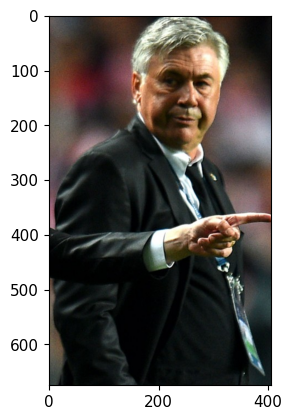

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


sample 0: [('quill, quill pen', '0.2%'), ('Staffordshire bullterrier, Staffordshire bull terrier', '0.2%'), ('sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita', '0.2%'), ('sunglass', '0.2%'), ('hammer', '0.2%')]


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [6]:
image = "https://ultralytics.com/images/zidane.jpg"

output = inference(image=image, cls_custom="person")